# Importing libraries

In [ ]:
import torch
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
import torch.nn as nn

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
from urllib.request import urlretrieve
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

# Dataset preprocessing

In [ ]:
class MaskImageDataset:
    """
    Basic class to download clean images and generate masks.
    """

    def __init__(self, from_file=None):
        """
        Load dataset from file if specified.
        Otherwise automaticly download and create from scratch.
        """

        if not from_file is None:
            self.load_dataset(from_file)
            return
        # Load some images
        self.images = self.load_images()
        # Add masks to images
        self.masked_images = torch.cat(
            [self.mask_image(image).unsqueeze(0) for image in self.images]
            , dim=0)

    def load_images(self) -> torch.Tensor:
        """
        Load image from the internet.
        """
        return torch.tensor([])

    def mask_image(self, image: torch.Tensor) -> torch.Tensor:
        """
        Create a mask for image.
        """
        return image

    def get_image(self, index):
        """
        Give image by index.
        """
        return self.images[index]

    def get_masked_image(self, index):
        """
        Give image with mask by index.
        """
        return self.masked_images[index]

    def save_dataset(self, filename="dataset.pt"):
        """
        Save any dataset to a file.
        """
        torch.save({
            "images": self.images,
            "masked_images": self.masked_images
        }, filename)

    def load_dataset(self, filename="dataset.pt"):
        """
        Load a dataset from a file.
        """
        dataset = torch.load(filename)
        self.images = dataset["images"]
        self.masked_images = dataset["masked_images"]

    def pack_to_dataloaders(self, batch_size=32, train_fraction=0.7) -> tuple[DataLoader, DataLoader]:
        """
        Pack image data into dataloaders for model training.
        """
        images_dataset = TensorDataset(self.masked_images, self.images)
        images_train, images_val = random_split(images_dataset, [train_fraction, 1-train_fraction])
        return (DataLoader(images_train, batch_size=batch_size, shuffle=False),
                DataLoader(images_val, batch_size=batch_size, shuffle=True))

    def __len__(self):
        return self.images.shape[0]


In [ ]:
class CIFAR10Masked(MaskImageDataset):
    """
    CIFAR10 dataset with 32x32 RGB images.
    """

    def load_images(self) -> np.array:
        # Load images using keras
        (images1, _), (images2, _) = tf.keras.datasets.cifar10.load_data()
        torch_data = torch.cat((torch.tensor(images1, dtype=torch.float32)/255, torch.tensor(images2, dtype=torch.float32)/255), dim=0)
        return torch_data.permute((0, 3, 1, 2))

    def mask_image(self, image: torch.Tensor) -> np.array:
        image = image.permute((1, 2, 0))
        # Generate random top-left coordinates.
        x1, y1 = np.random.randint(0, 26, size=2)
        # Generate random bottom-right coordinates
        min_w, min_h, max_w, max_h = 5, 5, 9, 9
        x2 = np.random.randint(min(x1+min_w,32), min(x1+max_w,32))
        y2 = np.random.randint(min(y1+min_h,32), min(y1+max_h,32))
        # Copy original image
        masked_image = image.clone().detach()
        # Fill black rectange on generated coordinates
        mask = torch.tensor(np.zeros((y2-y1)*(x2-x1)*3).reshape(y2-y1,x2-x1,3))
        masked_image[y1:y2,x1:x2] = mask
        # Return result
        return masked_image.permute((2, 0, 1))

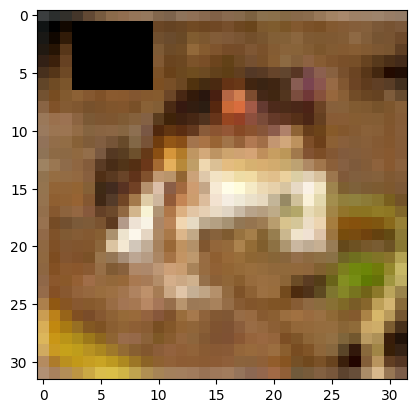

In [ ]:
# Test for CIFAR10
cifar10_test = CIFAR10Masked()
train_loader, test_loader = cifar10_test.pack_to_dataloaders(batch_size=64)
cifar10_test.save_dataset(filename="cifar10.pt")
plt.imshow(cifar10_test.get_masked_image(0).permute((1, 2, 0)))

In [ ]:
# From hugging face
class AquaMagicBrushMasked(MaskImageDataset):
    """
    Dataset that was used to train Aqua Magic Brush.
    """

    def __init__(self):
        self.images, self.masked_images = self.load_images()

    def load_images(self) -> np.array:
        # WARNING: If you want to add 'filtered' or 'extra' .parquet files. Do not do this.
        # Extra - are unfiltered.
        # Filtered - are filtered only from humans.
        urls = [
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00000-of-00004-e162115722f1be56.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00001-of-00004-d51ef97cecd37906.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00002-of-00004-e1736c6f52875d53.parquet",
            "https://huggingface.co/datasets/ImagenHub/Text_Guided_Image_Editing/resolve/main/data/dev-00003-of-00004-93e3835eaca42171.parquet"
        ]

        mask_images = []
        images = []
        self.test_im = None

        for i, url in enumerate(urls):
            if not os.path.isfile(f"dev{i+1}.parquet"):
                print(f"Downloading {i+1}/{len(urls)}")
                urlretrieve(url, f"dev{i+1}.parquet")
            print(f"Parsing {i+1}/{len(urls)}")
            data = pd.read_parquet(f"dev{i+1}.parquet")
            for entry in data["source_img"]:
                image = Image.open(io.BytesIO(entry["bytes"]))
                if self.test_im == None:
                    self.test_im = image.resize((500, 500)).convert('RGB')
                image = image.resize((500, 500)).convert('RGB') # All images must have equal size? (временно)
                images.append(torch.tensor(np.asarray(image)).unsqueeze(0))

            for entry in data["mask_img"]:
                mask_image = Image.open(io.BytesIO(entry["bytes"]))
                mask_image = mask_image.resize((500, 500)).convert('RGB')
                mask_images.append(torch.tensor(np.asarray(mask_image)).unsqueeze(0))

        return torch.cat(images, dim=0), torch.cat(mask_images, dim=0)

Parsing 1/4
Parsing 2/4
Parsing 3/4
Parsing 4/4


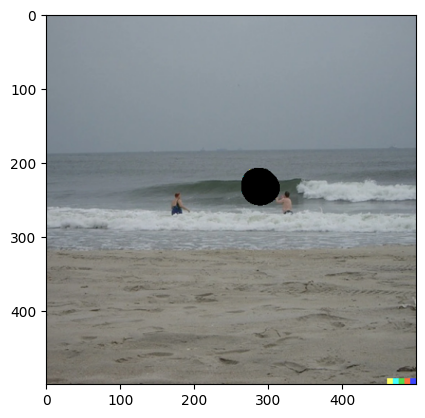

In [ ]:
# Test for Aqua Magic Brush dataset
aqua_test = AquaMagicBrushMasked()
train_loader, test_loader = aqua_test.pack_to_dataloaders()
aqua_test.save_dataset(filename="aqua.pt")

plt.imshow(aqua_test.get_masked_image(0).view(500, 500, 3))

In [ ]:
# Implement if you want XD
class ImageNetMasked(MaskImageDataset):
    """
    Description
    """

    def load_images(self) -> np.array:
        pass

    def mask_image(self, image: np.array) -> np.array:
        pass

In [ ]:
# Test for ImageNet

Implement other dataset if you want. Please follow format for easier development.

# Model(s)

In [ ]:
# Will be done in future
class DummyVAE(nn.Module):
    def __init__(self, image_channels, init_channels, latent_dim):
        super(DummyVAE, self).__init__()
        kernel_size=(4,4)
        self.conv_encode_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=init_channels*4, out_channels=64, kernel_size=kernel_size,
                stride=2, padding=0
            ),
            nn.AdaptiveAvgPool2d(1)
        )
        self.linear_encode_layer = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.conv_decode_layer = nn.Sequential()
        self.linear_decode_layer = nn.Linear(latent_dim, 64)
        self.conv_decode_layer = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
                stride=1, padding=0
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=init_channels*2, out_channels=image_channels, kernel_size=kernel_size,
                stride=2, padding=1
            ),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv_encode_layer(x)
        hidden = self.linear_encode_layer(x.reshape(batch_size, -1))

        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        z = self.reparameterize(mu, log_var)
        z = self.linear_decode_layer(z)
        z = z.view(-1, 64, 1, 1)

        reconstruction = self.conv_decode_layer(z)
        return reconstruction, mu, log_var

# Training loop

In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
# Will be done in future
def train_one_epoch(model, train_loader, optimizer, loss_fn):
    model.train()
    running_loss = 0.0
    total = 0
    data = tqdm(enumerate(train_loader), total=int(len(cifar10_test)/train_loader.batch_size))
    for i, batch in data:
        total += 1
        input, target = batch
        #print(input.shape)
        #print(target.shape)
        optimizer.zero_grad()
        reconstruction, mu, log_var = model(input)
        #print(reconstruction.shape)
        bce_loss = loss_fn(reconstruction, target)
        loss = final_loss(bce_loss, mu, log_var)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss / total

In [ ]:
model = DummyVAE(3, 4, 128)


epochs = 20
batch_size = 64
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss(reduction='sum')


for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
    print(train_loss)

 70%|███████   | 657/937 [00:21<00:09, 30.03it/s]


127290.4589814022


 70%|███████   | 657/937 [00:22<00:09, 29.24it/s]


123187.4185246623


 70%|███████   | 657/937 [00:22<00:09, 29.04it/s]


121625.57006575818


 70%|███████   | 657/937 [00:22<00:09, 29.34it/s]


120887.13819325533


 70%|███████   | 657/937 [00:23<00:10, 27.84it/s]


120498.61241022166


 70%|███████   | 657/937 [00:23<00:10, 27.67it/s]


120169.84084855403


 70%|███████   | 657/937 [00:22<00:09, 29.14it/s]


119943.48019525304


 70%|███████   | 657/937 [00:22<00:09, 29.22it/s]


119833.95981081146


 70%|███████   | 657/937 [00:22<00:09, 29.21it/s]


119734.26546149638


 70%|███████   | 657/937 [00:21<00:09, 30.63it/s]


119576.25255362918


 70%|███████   | 657/937 [00:22<00:09, 29.27it/s]


119542.85625059456


 70%|███████   | 657/937 [00:22<00:09, 29.13it/s]


119503.68175359114


 70%|███████   | 657/937 [00:22<00:09, 29.83it/s]


119451.75615070871


 70%|███████   | 657/937 [00:21<00:09, 30.12it/s]


119354.03861063547


 70%|███████   | 657/937 [00:22<00:09, 29.31it/s]


119222.9230641172


 70%|███████   | 657/937 [00:22<00:09, 29.23it/s]


119185.06315104167


 70%|███████   | 657/937 [00:21<00:09, 30.63it/s]


119143.50136451199


 70%|███████   | 657/937 [00:23<00:09, 28.17it/s]


119021.15125570777


 70%|███████   | 657/937 [00:22<00:09, 29.06it/s]


118855.0215230213


 70%|███████   | 657/937 [00:22<00:09, 29.28it/s]

118721.44581490202


# Test and evaluation

torch.Size([1, 3, 32, 32])


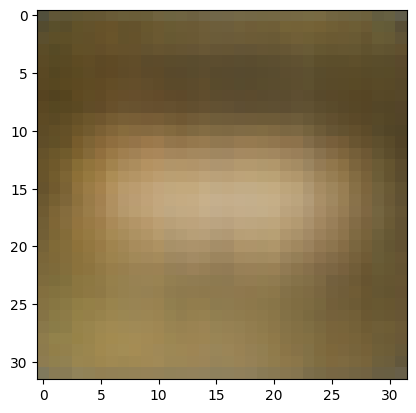

In [ ]:
# Will be done in future
with torch.no_grad():
    model.eval()
    result = model(cifar10_test.get_masked_image(0).view(1, 3, 32, 32))
    print(result[0].shape)
    plt.imshow(result[0][0].permute((1,2,0)))